# Example: Using the PD Simulator for Mortgage Portfolio

This notebook demonstrates how to use the `pd_simulator.py` module from the `irbstudio.simulation` package to simulate Probability of Default (PD) for a mortgage portfolio.

We will:
1. Import required libraries
2. Import the `pd_simulator` module
3. Generate a realistic mortgage portfolio dataset (5000+ facilities with 36-month history)
4. Run the simulation using the `pd_simulator` module
5. Visualize the results

## 1. Import Required Libraries

We will use pandas for data manipulation and matplotlib for visualization. If you want interactive plots, you can also use plotly.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Optional: import plotly.express as px for interactive plots

# Set matplotlib to display plots inline
%matplotlib inline

## 2. Import pd_simulator Module

We import the `pd_simulator` module from the `irbstudio.simulation` package. If running outside the package root, you may need to adjust the Python path.

In [2]:
from irbstudio.simulation import pd_simulator

## 3. Load Mortgage Portfolio Dataset

We will load the sample portfolio data from the `sample_portfolio_data.csv` file. This file should be generated first by running the `examples/sample_data.py` script.

The dataset contains the following key columns:
- `facility_id`: Unique identifier for each mortgage.
- `observation_date`: The month of the observation.
- `exposure`: The outstanding principal amount.
- `rating`: The assigned credit rating for that month.
- `score`: A risk score, where a higher score indicates a higher probability of default (PD).
- `default_flag`: A flag indicating if the facility is in default.
- `into_default_flag`: A forward-looking flag indicating if the facility will default within the next 12 months.

In [3]:
# Load the dataset from the CSV file generated by `examples/sample_data.py`
# The path is relative to the notebook's location in the `notebooks` directory.
try:
    portfolio_df = pd.read_csv('../data/sample_portfolio_data.csv', parse_dates=['observation_date'])
    print("Successfully loaded `sample_portfolio_data.csv`.")
except FileNotFoundError:
    print("Error: `sample_portfolio_data.csv` not found.")
    print("Please run the `examples/sample_data.py` script first to generate the data.")
    portfolio_df = pd.DataFrame()

if not portfolio_df.empty:
    # Display info
    latest_observations = portfolio_df.sort_values('observation_date').groupby('facility_id').last()
    default_rate = (latest_observations['rating'] == 'D').mean()
    
    print(f"\nTotal facilities: {portfolio_df['facility_id'].nunique()}")
    print(f"Total observations: {len(portfolio_df)}")
    print(f"Date range: {portfolio_df['observation_date'].min().date()} to {portfolio_df['observation_date'].max().date()}")
    print(f"Current default rate: {default_rate:.4f} ({default_rate*100:.2f}%)")
    
    print("\nRating distribution (latest observation for each facility):")
    print(latest_observations['rating'].value_counts().sort_index())
    
    print("\nPortfolio characteristics:")
    print(latest_observations[['exposure', 'score']].describe())
    
    print("\nSample data:")
    print(portfolio_df.head())

Successfully loaded `sample_portfolio_data.csv`.

Total facilities: 10000
Total observations: 636802
Date range: 2015-01-31 to 2025-12-31
Current default rate: 0.0517 (5.17%)

Rating distribution (latest observation for each facility):
rating
1    1452
2    1995
3    1816
4    2378
5    1506
6     322
7      14
D     517
Name: count, dtype: int64

Portfolio characteristics:
            exposure         score
count   10000.000000  10000.000000
mean   427862.806200      0.201710
std    236667.024420      0.215277
min     24382.832281      0.010000
25%    227243.842389      0.076122
50%    412504.473102      0.141753
75%    610065.132446      0.240671
max    991090.477431      1.000000

Sample data:
  facility_id observation_date       exposure  default_flag  \
0   FAC_00000       2018-01-31  484083.717682             0   
1   FAC_00000       2018-02-28  482359.399678             0   
2   FAC_00000       2018-03-31  480635.081675             0   
3   FAC_00000       2018-04-30  478910.763

## 4. Run PD Simulation

Now we'll configure the PD simulation and run it using the `pd_simulator` module. We'll set up the simulation parameters based on our mortgage portfolio characteristics.

In [4]:

# Define the score-to-rating boundaries based on the logic in sample_data.py
# These are used to map the output `simulated_pd` back to a `simulated_rating`.
# The keys are ratings, values are (lower_bound, upper_bound) of the PD.
score_to_rating_bounds = {
    '1': (0.00, 0.05),
    '2': (0.05, 0.10),
    '3': (0.10, 0.15),
    '4': (0.15, 0.25),
    '5': (0.25, 0.40),
    '6': (0.40, 0.60),
    '7': (0.60, 0.80),
    '8': (0.80, 0.95),
    '9': (0.95, 1.01)
}

# Run the PD simulation using the actual pd_simulator module
print("Running PD simulation for the loaded portfolio...")

if not portfolio_df.empty:
    try:
        result_df = pd_simulator.simulate_portfolio(
            portfolio_df=portfolio_df,
            score_to_rating_bounds=score_to_rating_bounds,
            rating_col='rating',
            loan_id_col='facility_id',
            date_col='observation_date',
            default_col='default_flag',
            into_default_flag_col='into_default_flag',
            score_col='score',
            asset_correlation=0.15,
            target_auc=0.85,  # Optional: target AUC for new client scores
        )

        # Display summary statistics
        print(f"\nTotal observations in simulation output: {len(result_df)}")
        print(f"Number of unique facilities: {result_df['facility_id'].nunique()}")
        print(f"Simulated date range: {result_df['observation_date'].min().date()} to {result_df['observation_date'].max().date()}")
        
        # Show a sample of the simulation results, including new columns
        print("\nSample of simulation results:")
        print(result_df[['facility_id', 'observation_date', 'rating', 'simulated_rating', 'simulated_pd']].head())

    except Exception as e:
        print(f"\nAn error occurred during simulation: {e}")
        print("Please ensure the `pd_simulator.py` module is correctly implemented and all required columns are present.")
        result_df = pd.DataFrame() # Create empty df to avoid breaking downstream cells
else:
    print("Portfolio DataFrame is empty. Skipping simulation.")
    result_df = pd.DataFrame()

Running PD simulation for the loaded portfolio...
2025-09-14 21:02:28 - irbstudio.simulation.distribution - INFO - Supervised fitting complete.
2025-09-14 21:02:28 - irbstudio.simulation.distribution - INFO - Non-Default (C0): alpha=1.58, beta=8.28, weight=0.99
2025-09-14 21:02:28 - irbstudio.simulation.distribution - INFO - Default (C1): alpha=2.22, beta=7.21, weight=0.01
2025-09-14 21:02:28 - irbstudio.simulation.score_generation - INFO - Searching for gamma to achieve target AUC of 0.85...
2025-09-14 21:02:28 - irbstudio.simulation.score_generation - INFO - Found calibrated gamma of 1.3523.
2025-09-14 21:02:28 - irbstudio.simulation.distribution - INFO - Applied AUC calibration with gamma=1.352 for target AUC 0.850
2025-09-14 21:02:28 - irbstudio.simulation.score_generation - INFO - Searching for gamma to achieve target AUC of 0.85...
2025-09-14 21:02:29 - irbstudio.simulation.score_generation - INFO - Found calibrated gamma of 1.3494.
2025-09-14 21:02:29 - irbstudio.simulation.dist

C:\Users\jacek\Desktop\Projects\IRBStudio\irbstudio\simulation\pd_simulator.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historical_df['idiosyncratic_score'] = np.nan
C:\Users\jacek\Desktop\Projects\IRBStudio\irbstudio\simulation\pd_simulator.py:254: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  existing_clients_df = existing_clients_df_sorted.groupby(loan_id_col, group_keys=False).apply(
C:\Users\jacek\Desktop\Projects\IRBStudio\irbstudio\simulation\pd


Total observations in simulation output: 636802
Number of unique facilities: 10000
Simulated date range: 2015-01-31 to 2025-12-31

Sample of simulation results:
  facility_id observation_date rating simulated_rating  simulated_pd
0   FAC_00000       2018-01-31      4                6      0.025051
1   FAC_00000       2018-02-28      4                6      0.025051
2   FAC_00000       2018-03-31      4                6      0.025051
3   FAC_00000       2018-04-30      4                6      0.025051
4   FAC_00000       2018-05-31      4                6      0.025051


## 5. Analyze and Visualize Simulation Results

Let's analyze the key results from our mortgage portfolio simulation and create some useful visualizations.

In [5]:
# Perform basic analysis of simulation results, if the simulation was successful
if not result_df.empty:
    # Use the most recent simulated data for analysis
    analysis_df = result_df.sort_values('observation_date').groupby('facility_id').last().reset_index()

    # 1. Analyze rating migration from original to simulated
    migration_matrix = pd.crosstab(
        analysis_df['rating'], 
        analysis_df['simulated_rating'],
        normalize='index'
    )

    print("Rating migration matrix (Original vs. Simulated):")
    print(migration_matrix.round(3))



    # 3. Summarize simulated portfolio quality
    final_default_rate = (analysis_df['simulated_rating'] == 'D').mean()
    print(f"\nFinal simulated default rate: {final_default_rate:.4f} ({final_default_rate*100:.2f}%)")

    # Prepare data for visualization
    visualization_data = {
        'migration_matrix': migration_matrix,
        'rating_transitions': analysis_df[['rating', 'simulated_rating']],
    }
else:
    print("Simulation did not produce results. Skipping analysis.")
    visualization_data = {}

Rating migration matrix (Original vs. Simulated):
simulated_rating      3      4      5      6      7    D
rating                                                  
1                 0.033  0.261  0.600  0.106  0.000  0.0
2                 0.031  0.272  0.590  0.107  0.000  0.0
3                 0.028  0.273  0.588  0.111  0.000  0.0
4                 0.030  0.267  0.600  0.102  0.001  0.0
5                 0.019  0.285  0.572  0.122  0.001  0.0
6                 0.031  0.212  0.651  0.106  0.000  0.0
7                 0.000  0.077  0.615  0.308  0.000  0.0
D                 0.000  0.000  0.000  0.000  0.000  1.0

Final simulated default rate: 0.0517 (5.17%)


C:\Users\jacek\AppData\Local\Temp\ipykernel_20524\2890943954.py:66: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax4.legend(title='PD Type')


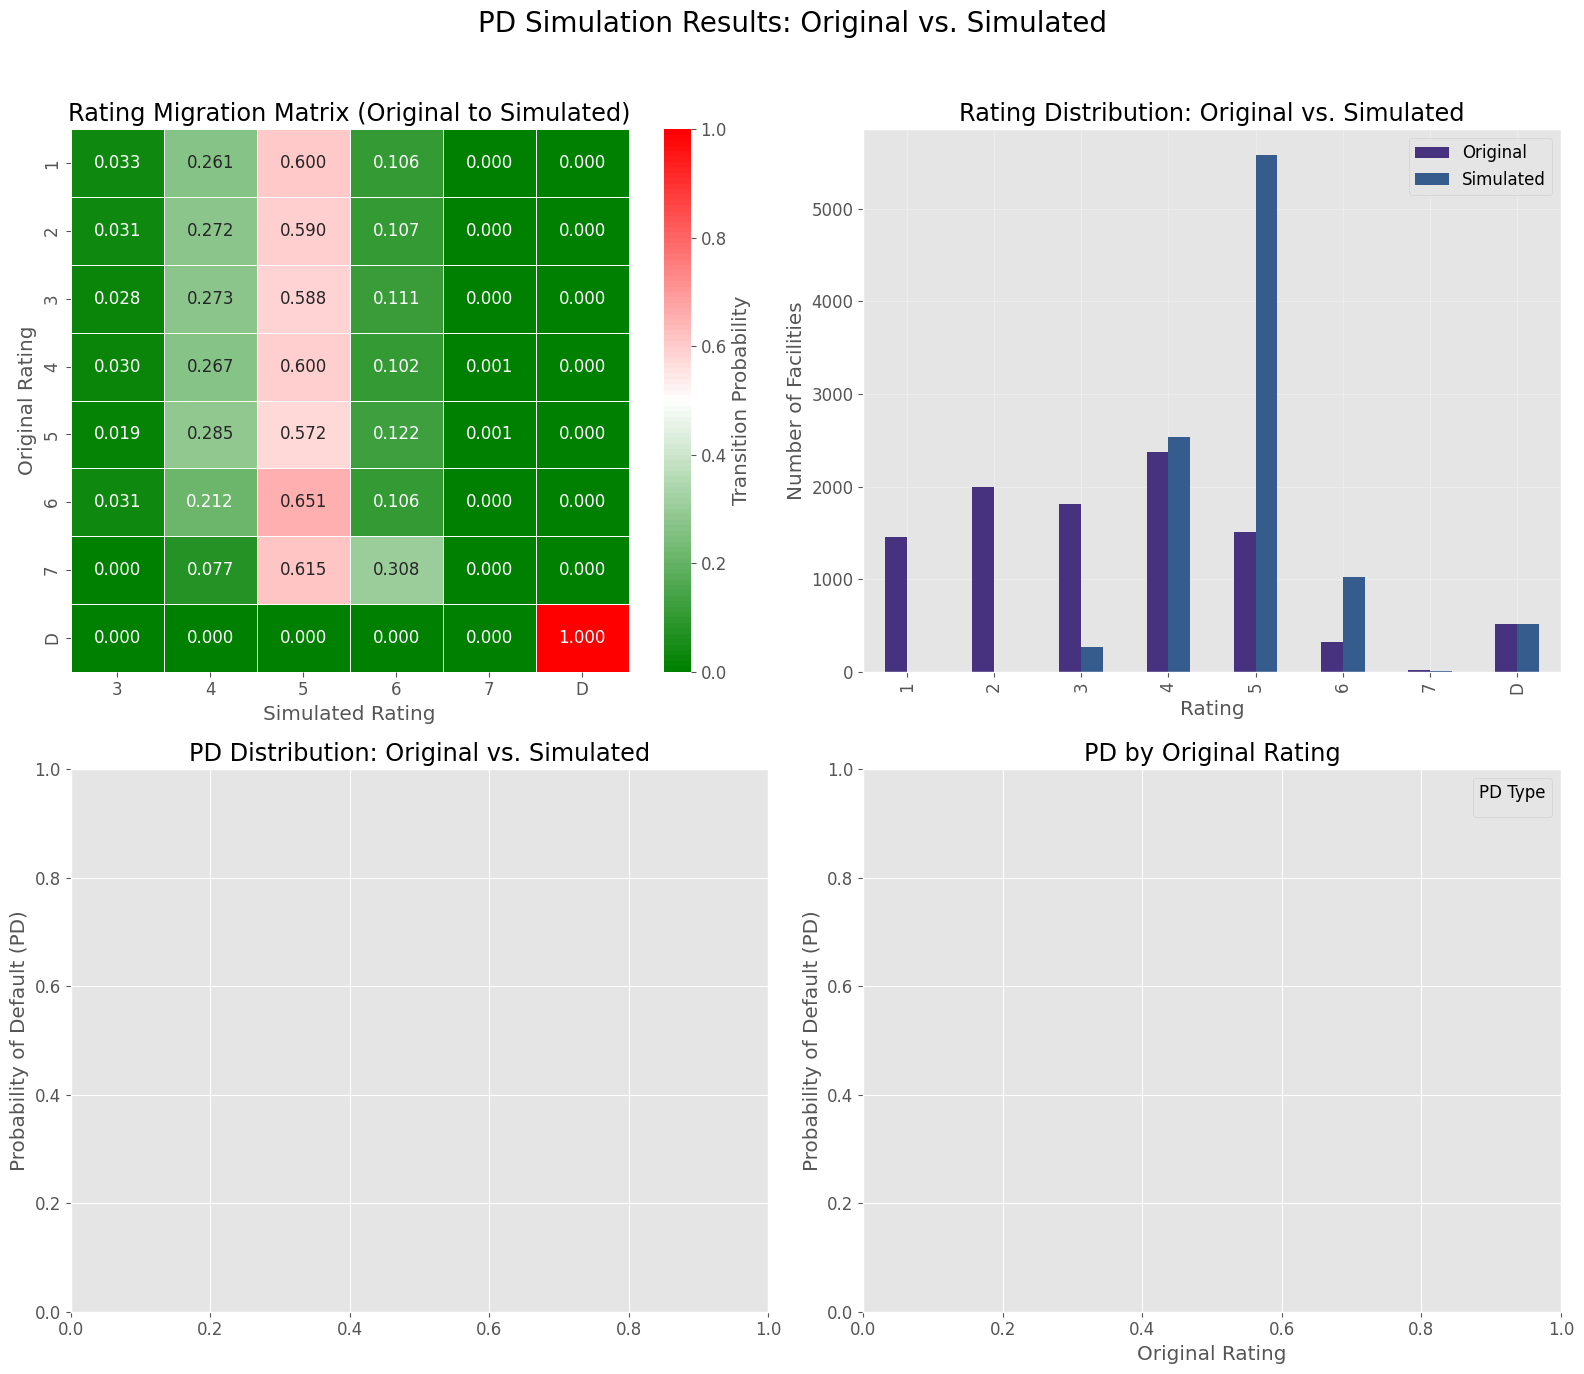

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Set up a more professional plot style
plt.style.use('ggplot')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

if visualization_data:
    # Create a figure with subplots for key visualizations
    fig = plt.figure(figsize=(16, 14))
    fig.suptitle('PD Simulation Results: Original vs. Simulated', fontsize=20)

    # 1. Heatmap of migration matrix
    ax1 = plt.subplot(2, 2, 1)
    colors = ["green", "white", "red"]
    cm = LinearSegmentedColormap.from_list("custom", colors, N=100)

    def sort_ratings(ratings):
        numeric_ratings = sorted([r for r in ratings if r != 'D'])
        return numeric_ratings + ['D'] if 'D' in ratings else numeric_ratings

    migration_matrix = visualization_data['migration_matrix']
    row_ratings = sort_ratings(migration_matrix.index)
    col_ratings = sort_ratings(migration_matrix.columns)
    sorted_matrix = migration_matrix.reindex(index=row_ratings, columns=col_ratings).fillna(0)

    sns.heatmap(sorted_matrix, cmap=cm, annot=True, fmt='.3f', 
                linewidths=0.5, ax=ax1, vmin=0, vmax=1, cbar_kws={'label': 'Transition Probability'})
    ax1.set_title('Rating Migration Matrix (Original to Simulated)')
    ax1.set_xlabel('Simulated Rating')
    ax1.set_ylabel('Original Rating')

    # 2. Rating distribution before and after simulation
    ax2 = plt.subplot(2, 2, 2)
    rating_transitions = visualization_data['rating_transitions']
    start_counts = rating_transitions['rating'].value_counts().sort_index()
    end_counts = rating_transitions['simulated_rating'].value_counts().sort_index()
    
    rating_counts = pd.DataFrame({'Original': start_counts, 'Simulated': end_counts}).fillna(0)
    sorted_ratings = sort_ratings(rating_counts.index)
    rating_counts = rating_counts.reindex(sorted_ratings)

    rating_counts.plot(kind='bar', ax=ax2)
    ax2.set_title('Rating Distribution: Original vs. Simulated')
    ax2.set_xlabel('Rating')
    ax2.set_ylabel('Number of Facilities')
    ax2.grid(True, alpha=0.3)

    # 3. PD distribution comparison (violin plot)
    ax3 = plt.subplot(2, 2, 3)

    ax3.set_title('PD Distribution: Original vs. Simulated')
    ax3.set_ylabel('Probability of Default (PD)')

    # 4. PD comparison by original rating
    ax4 = plt.subplot(2, 2, 4)
    pd_full_comparison = analysis_df[['rating', 'simulated_pd']].copy()
    
    
    ax4.set_title('PD by Original Rating')
    ax4.set_xlabel('Original Rating')
    ax4.set_ylabel('Probability of Default (PD)')
    ax4.legend(title='PD Type')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

else:
    print("No data to visualize.")

## Conclusion

This example demonstrates how to use the PD simulator module to model default risk in a mortgage portfolio. The simulation provides valuable insights into:

1. **Default Rates**: The monthly and cumulative default rates across different scenarios.

2. **Rating Migration**: How mortgages transition between rating categories over time.

3. **Risk Factors**: The relationship between LTV ratios and default probability.

4. **Portfolio Quality**: Changes in the overall distribution of ratings from start to end.

These insights can be used for:
- Regulatory capital calculations
- IFRS 9/CECL expected credit loss estimation
- Stress testing
- Mortgage portfolio risk management
- Pricing and underwriting strategy

By using the `pd_simulator` module, financial institutions can efficiently model credit risk in their mortgage portfolios without implementing complex simulation logic from scratch.